## Installing TFF Version 0.20.0

In [1]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade tensorflow-model-optimization
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

%load_ext tensorboard

!pip install tensorflow
!pip install --quiet tensorflow-federated==0.20.0
!pip install matplotlib==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 KB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.8/243.8 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 KB 59.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 KB 38.5 MB/s et

## Importing all the required libraries

In [20]:
import collections
import random
from typing import Any, List, Optional, Sequence
import dp_accounting
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd

np.random.seed(0)

### Checking setup of TFF environment

In [21]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()
# tf.config.list_physical_devices('GPU')

b'Hello, World!'

## Loading Dataset

In [22]:
def element_fn(element):
  return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return (dataset.map(element_fn)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

def preprocess_test_dataset(dataset):
  return dataset.map(element_fn).batch(128, drop_remainder=False)

def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)
  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test
train_data, test_data = get_emnist_dataset()

### Exploring Datset & Dataset Characterstics

In [23]:
def preprocess(dataset):

  def map_fn(element):
    # Rename the features from `pixels` and `label`, to `x` and `y` for use with
    # Keras.
    return collections.OrderedDict(
        # Transform each `28x28` image into a `784`-element array.
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  # Shuffle the individual examples and `repeat` over several epochs.
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).map(map_fn)

In [24]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

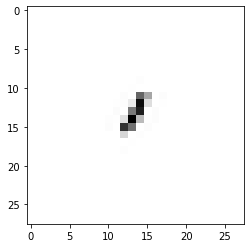

In [25]:
import matplotlib.pyplot as plt

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

In [26]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

NUM_EPOCHS = 5
SHUFFLE_BUFFER = 100
preprocessed_example_dataset = preprocess(example_dataset)


example_element = next(iter(example_dataset))

example_element['label'].numpy()

1

***Showing each client have multiple images and different values to input***

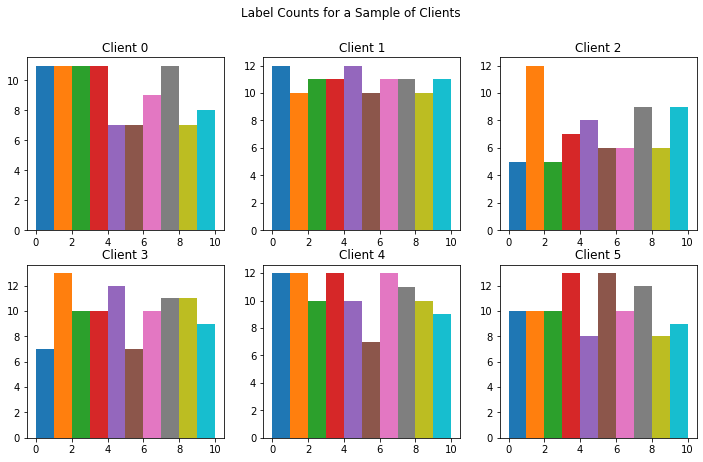

In [27]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### Define our model

In [28]:
def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### Determining the noise sensitivity of the model

In [29]:
total_clients = len(train_data.client_ids)
clients_per_thread = 5

# Create a local executor with a fixed number of threads
num_threads = total_clients // clients_per_thread
local_executor = tff.framework.local_executor_factory(num_threads)

# Create a local execution context with the executor
local_execution_context = tff.framework.ExecutionContext(local_executor)

# Set the local execution context as the default context
tff.framework.set_default_context(local_execution_context)

In [30]:
def train(rounds, noise_multiplier, clients_per_round, data_frame):
  # Using the `dp_aggregator` here turns on differential privacy with adaptive
  # clipping.
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  # prematurely.
  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)
    
  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    if round % 5 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [test_data])['eval']
      if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)

    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        train_data.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    # Use selected clients for update.
    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame

In [13]:
import warnings
warnings.filterwarnings('ignore')


data_frame = pd.DataFrame()
rounds = 50
clients_per_round = 50

for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09389694), ('loss', 2.4363313), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.17601392), ('loss', 2.2115083), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.33956212), ('loss', 2.1032736), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.4866526), ('loss', 1.9080837), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.6484375), ('loss', 1.6766436), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.6471885), ('loss', 1.4640253), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7611432), ('loss', 0.7853521), ('num_examples', 40832), ('num_batches', 

## Visualising the Evaluation set and accuracy and loss associated to them

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

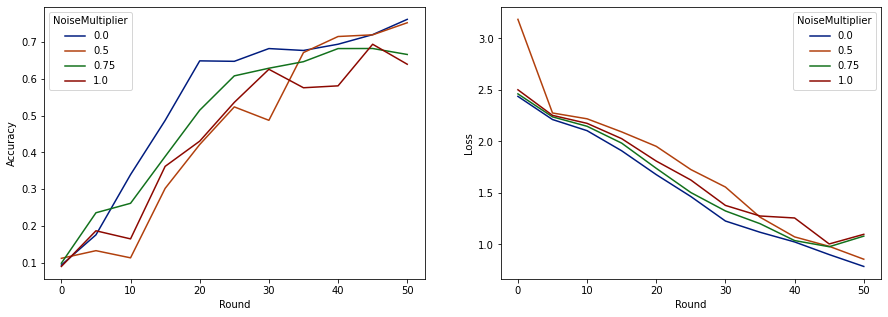

In [15]:
make_plot(data_frame)

In [32]:
total_clients = 3383
noise_to_clients_ratio = 0.01
target_delta = 1e-5
target_eps = 2
rounds=50
# Initialize arguments to dp_accounting.calibrate_dp_mechanism.

# No-arg callable that returns a fresh accountant.
make_fresh_accountant = dp_accounting.rdp.RdpAccountant

# Create function that takes expected clients per round and returns a 
# dp_accounting.DpEvent representing the full training process.
def make_event_from_param(clients_per_round):
  q = clients_per_round / total_clients
  noise_multiplier = clients_per_round * noise_to_clients_ratio
  gaussian_event = dp_accounting.GaussianDpEvent(noise_multiplier)
  sampled_event = dp_accounting.PoissonSampledDpEvent(q, gaussian_event)
  composed_event = dp_accounting.SelfComposedDpEvent(sampled_event, rounds)
  return composed_event

# Create object representing the search range [1, 3383].
bracket_interval = dp_accounting.ExplicitBracketInterval(1, total_clients)

# Perform search for smallest clients_per_round achieving the target privacy.
clients_per_round = dp_accounting.calibrate_dp_mechanism(
    make_fresh_accountant, make_event_from_param, target_eps, target_delta,
    bracket_interval, discrete=True
)

noise_multiplier = clients_per_round * noise_to_clients_ratio
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')


To get (2, 1e-05)-DP, use 104 clients with noise multiplier 1.04.


In [33]:
!pip install nest_asyncio
import nest_asyncio
import warnings

warnings.filterwarnings('ignore')
nest_asyncio.apply()


rounds = 50
noise_multiplier = 1.04
clients_per_round = 120
# total_clients = 3383
data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.098427705), ('loss', 2.5169594), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.14630681), ('loss', 2.2472532), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.3645915), ('loss', 2.1319683), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.53369904), ('loss', 1.9543078), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5737412), ('loss', 1.7561852), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.6170406), ('loss', 1.536851), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7557063), ('loss',

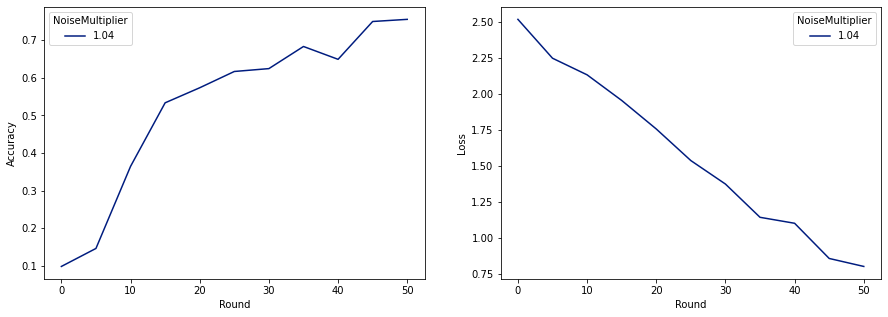

In [38]:
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')


make_plot(data_frame)